# Setting up our Schema

Spark can automatically create a schema for CSV files, but ours don't have headings. Let's set this up here:

In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

print(schema)


StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true),StructField(sensible_heat_net_flux_surface,FloatType,true),StructField(categorical_ice_pellets_yes1_no0_surface,FloatType,true),StructField(visibility_surface,FloatType,true),StructField(number_of_soil_layers_in_root_zone_surface,FloatType,true),StructField(categorical_freezing_rain_yes1_no0_surface,FloatType,true),StructField(pressure_reduced_to_msl_msl,FloatType,true),StructField(upward_short_wave_rad_flux_surface,FloatType,true),StructField(relative_humidity_zerodegc_isotherm,FloatType,true),StructField(categorical_snow_yes1_no0_surface,FloatType,true),StructField(u-component_of_wind_tropopause,FloatType,true),StructField(surface_wind_gust_surface,FloatType,true),StructField(total_cloud_cover_entire_atmosphere,FloatType,tru

# Creating a Dataframe

Let's load our CSV into a 'dataframe' - Spark's abstraction for working with tabular data (built on top of RDDs)

In [2]:
nam_t = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:15000/nam_tiny.tdv')
nam_s = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:15000/nam_s/*')

In [3]:
nam_t.cache()
nam_s.cache()

DataFrame[Timestamp: bigint, Geohash: string, geopotential_height_lltw: float, water_equiv_of_accum_snow_depth_surface: float, drag_coefficient_surface: float, sensible_heat_net_flux_surface: float, categorical_ice_pellets_yes1_no0_surface: float, visibility_surface: float, number_of_soil_layers_in_root_zone_surface: float, categorical_freezing_rain_yes1_no0_surface: float, pressure_reduced_to_msl_msl: float, upward_short_wave_rad_flux_surface: float, relative_humidity_zerodegc_isotherm: float, categorical_snow_yes1_no0_surface: float, u-component_of_wind_tropopause: float, surface_wind_gust_surface: float, total_cloud_cover_entire_atmosphere: float, upward_long_wave_rad_flux_surface: float, land_cover_land1_sea0_surface: float, vegitation_type_as_in_sib_surface: float, v-component_of_wind_pblri: float, albedo_surface: float, lightning_surface: float, ice_cover_ice1_no_ice0_surface: float, convective_inhibition_surface: float, pressure_surface: float, transpiration_stress-onset_soil_mo

In [4]:
%%time
nam_t.head(1)
nam_s.head(1)

CPU times: user 66.6 ms, sys: 30.3 ms, total: 96.9 ms
Wall time: 5min 40s


# Playtime

In [6]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors

dataFrame = spark.createDataFrame([
    (0, Vectors.dense([1.0, 0.1, -1.0]),),
    (1, Vectors.dense([2.0, 1.1, 1.0]),),
    (2, Vectors.dense([3.0, 10.1, 3.0]),)
], ["id", "features"])

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(dataFrame)

# rescale each feature to range [min, max].
scaledData = scalerModel.transform(dataFrame)
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
scaledData.select("features", "scaledFeatures").show()



Features scaled to range: [0.000000, 1.000000]
+--------------+--------------+
|      features|scaledFeatures|
+--------------+--------------+
|[1.0,0.1,-1.0]| [0.0,0.0,0.0]|
| [2.0,1.1,1.0]| [0.5,0.1,0.5]|
|[3.0,10.1,3.0]| [1.0,1.0,1.0]|
+--------------+--------------+



# SQL

In [5]:
from pyspark.sql import functions as F

In [6]:
# Creating an SQL 'table'
nam_t.createOrReplaceTempView("nam_t")
nam_s.createOrReplaceTempView("nam_s")

In [7]:
%%time
spark.catalog.cacheTable("nam_t")
spark.catalog.cacheTable("nam_s")

CPU times: user 1.81 ms, sys: 2.97 ms, total: 4.78 ms
Wall time: 95.9 ms


# Warmup

#### Unknown Feature
I didn't know what albedo was, so I looked at its summary statistics. Still unsure, I looked up the definition: 'the proportion of the incident light or radiation that is reflected by a surface, typically that of a planet or moon.'

In [54]:
%%time
nam_s.describe('albedo_surface').show()

+-------+------------------+
|summary|    albedo_surface|
+-------+------------------+
|  count|         108000000|
|   mean|15.874667708333334|
| stddev|15.434493156127981|
|    min|               6.0|
|    max|              80.0|
+-------+------------------+

CPU times: user 15.1 ms, sys: 3.04 ms, total: 18.2 ms
Wall time: 45.8 s


#### Hot Hot Hot
The hottest tempurature in the dataset is `330.67431640625` (K) at location `d5f0jqerq27b` (21.13070154, -86.9520505; Benito Juárez, Quintana Roo, Mexico) at time `2015-08-23T18:00:00+00:00`. This record is not surprising, as it is near the equator in the summer. Looking at the other highest tempuratures which are near this highest one, it does not appear to be an anomaly. 

<img src="img/hot_hot_hot_map.png" alt="so_snowy_map" style="width: 500px;"/>

In [44]:
%%time
temp_desc = nam_s.select('Timestamp', 'Geohash', 'temperature_surface')\
    .orderBy("temperature_surface", ascending=False)
temp_desc.cache()
hottest_record = temp_desc.first()

CPU times: user 14.2 ms, sys: 6.62 ms, total: 20.8 ms
Wall time: 15.3 s


In [45]:
hottest_record['temperature_surface']

330.67431640625

In [47]:
hottest_record['Geohash']

'd5f0jqerq27b'

In [52]:
from datetime import datetime, timezone
timestamp = hottest_record['Timestamp'] / 1000
datetime.fromtimestamp(timestamp, timezone.utc).isoformat()

'2015-08-23T18:00:00+00:00'

In [55]:
%%time
temp_desc.show()

+-------------+------------+-------------------+
|    Timestamp|     Geohash|temperature_surface|
+-------------+------------+-------------------+
|1440352800000|d5f0jqerq27b|          330.67432|
|1440266400000|d5f0vd8eb80p|          330.64062|
|1430157600000|9g77js659k20|           330.6045|
|1439056800000|d5f0jqerq27b|          330.53662|
|1440612000000|d59d5yttuc5b|          330.48193|
|1440612000000|d59eqv7e03pb|          330.35693|
|1440612000000|d59dntd726gz|          330.23193|
|1440698400000|d59eqv7e03pb|           330.2207|
|1438279200000|d5f04xyhucez|          330.17993|
|1439488800000|d5dpds10m55b|           330.1499|
|1440266400000|d59sxjhg1uh0|          330.14062|
|1438279200000|d5dpds10m55b|          330.05493|
|1438279200000|d5f0fgg1kg5b|          330.05493|
|1440871200000|d59d5yttuc5b|          329.99902|
|1430157600000|9g7e0htfnepz|           329.9795|
|1439056800000|d59eknqv867b|          329.91162|
|1439488800000|d59eqv7e03pb|           329.8999|
|1439143200000|d59d5

#### So Snowy
The location where it snows most often is `c41xurr50ypb` (57.652667, -132.694194; Kitimat-Stikine D, BC, Canada). 

<img src="img/so_snowy_map.png" alt="so_snowy_map" style="width: 500px;"/>

In [9]:
so_snowy_1 = nam_s.select('Geohash', 'Timestamp', 'snow_depth_surface')\
    .withColumn('has_snow', F.when(F.col('snow_depth_surface') > 0, 1).otherwise(0))
so_snowy_1.createOrReplaceTempView('so_snowy_1')

In [25]:
%%time
so_snowy_2 = spark.sql("\
SELECT geohash, AVG(has_snow) AS prob_snow, COUNT(*) AS count \
FROM so_snowy_1 \
GROUP BY geohash \
ORDER BY prob_snow DESC")
so_snowy_2.cache()
so_snowy_2.show()

+------------+------------------+-----+
|     geohash|         prob_snow|count|
+------------+------------------+-----+
|c1gyqex11wpb|               1.0|  398|
|c1p5fmbjmkrz|               1.0|  387|
|c41xurr50ypb|               1.0|  409|
|c1nrnydywy00|0.9951219512195122|  410|
|c41xbfbfkp80|0.9949367088607595|  395|
|c1p48r7t4qh0|0.9928057553956835|  417|
|c4585eur3580|0.9927710843373494|  415|
|c43sdmg10700|0.9921259842519685|  381|
|c41ueb1jyypb|0.9900497512437811|  402|
|c44p3thkr700|0.9896103896103896|  385|
|c1nuq5290jup|0.9886104783599089|  439|
|c43kp9tv6krz|0.9873737373737373|  396|
|c1ph3rpnnt00|0.9859154929577465|  426|
|c41uhb4r5n00|0.9857482185273159|  421|
|c41yybzdh1zz|0.9857142857142858|  420|
|c43c1zbmntbp|0.9854014598540146|  411|
|c1pj08qnqjgz|0.9853300733496333|  409|
|c41zmbwmedpb|0.9852216748768473|  406|
|c43s5qjhy0xb|0.9848101265822785|  395|
|c438fqgmsm00|0.9840182648401826|  438|
+------------+------------------+-----+
only showing top 20 rows

CPU times: use

# Analysis

### Strangely Snowy 
One of the most snowy locations, `c43sdmg10700` (with precision of 4 characters, `c43s`, ), has neighbors such as `c43v` which have less snow; this is because the former is further inside a mountain range, while the latter is more outside.
<img src="img/strangely_snowy_map.png" alt="strangely_snowy_map" style="width: 100%;"/>

In [29]:
%%time
so_snowy_2.createOrReplaceTempView('so_snowy_2')
strangely_snowy = spark.sql("\
SELECT LEFT(geohash, 4) AS geo, AVG(prob_snow), SUM(count) \
FROM so_snowy_2 \
GROUP BY geo \
HAVING geo IN ('c43m', 'c43t', 'c43v', 'c43k', 'c43s', 'c43u', 'c437', 'c43e', 'c43g')")
strangely_snowy.show()

+----+------------------+----------+
| geo|    avg(prob_snow)|sum(count)|
+----+------------------+----------+
|c437|0.7717742325860891|      1616|
|c43s|0.8803841977296996|      1584|
|c43u|0.7536126408733747|      1637|
|c43g|0.8708405405130588|      2060|
|c43v|0.5661343216457871|      1270|
|c43k|0.8693357358431658|      1611|
|c43e| 0.831083167695307|      1658|
|c43m| 0.771628533529959|      1195|
|c43t|0.6226036721491652|      2043|
+----+------------------+----------+

CPU times: user 1.21 ms, sys: 1.17 ms, total: 2.37 ms
Wall time: 398 ms


### Lightning rod
The top 3 locations most likely to be struck by lightning are `9g3v`, `9g3h`, and `9q3m`.

<img src="img/lightning_rod_map.png" alt="lightning_rod_map" style="width: 100%;"/>

In [7]:
lightning_rod = spark.sql("\
                           SELECT LEFT(geohash, 4) AS geo4, SUM(lightning_surface) / COUNT(*) AS prob_lightning \
                           FROM nam_s \
                           GROUP BY geo4 \
                           ORDER BY prob_lightning DESC \
                           LIMIT 3")

In [8]:
%%time
lightning_rod.collect()

CPU times: user 56.4 ms, sys: 23.3 ms, total: 79.7 ms
Wall time: 4min 56s


[Row(geo4='9g3v', prob_lightning=0.3184),
 Row(geo4='9g3h', prob_lightning=0.29589905362776026),
 Row(geo4='9g3m', prob_lightning=0.29389942291838417)]

### Drying out
In the San Francisco Bay Area (defined in the Sampling section), the driest (i.e. least humid) month is August, as seen in the humidity values averaged for each month below.

In [11]:
nam_s_bayarea = spark.read.format('csv').option('sep', ',').schema(schema).load('hdfs://orion11:15000/nam_s_bayarea/*')
nam_s_bayarea.createOrReplaceTempView("nam_s_bayarea")
spark.catalog.cacheTable("nam_s_bayarea")

In [12]:
drying_out = spark.sql("\
    SELECT \
        trunc(from_unixtime(timestamp DIV 1000), 'MM') AS year_month, \
        AVG(relative_humidity_zerodegc_isotherm) AS avg_humidity, \
        COUNT(*) AS count \
    FROM nam_s_bayarea \
    GROUP BY year_month \
    ORDER BY year_month")

In [13]:
%%time
drying_out.show()

+----------+------------------+-----+
|year_month|      avg_humidity|count|
+----------+------------------+-----+
|2015-01-01|31.324879025529786| 5993|
|2015-02-01|28.585786986550346| 5502|
|2015-03-01| 23.24552213585671| 5918|
|2015-04-01| 35.07409362900387| 5682|
|2015-05-01| 30.44884776536313| 5728|
|2015-06-01| 25.14540059347181| 5729|
|2015-07-01|35.376506024096386| 5644|
|2015-08-01|22.981870400287203| 5571|
|2015-09-01| 29.28472104459895| 5897|
|2015-10-01|31.750963222416814| 5710|
|2015-11-01|38.616337929830685| 5729|
|2015-12-01| 50.35549132947977| 5536|
+----------+------------------+-----+

CPU times: user 2.31 ms, sys: 3.25 ms, total: 5.56 ms
Wall time: 1.73 s


In [82]:
monthly_humidity = drying_out.collect();

In [83]:
months = list(map(lambda row: row['year_month'].month, monthly_humidity))
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [84]:
humidities = list(map(lambda row: row['avg_humidity'], monthly_humidity))
humidities

[31.324879025529786,
 28.585786986550346,
 23.24552213585671,
 35.07409362900387,
 30.44884776536313,
 25.14540059347181,
 35.376506024096386,
 22.981870400287203,
 29.28472104459895,
 31.750963222416814,
 38.616337929830685,
 50.35549132947977]

In [67]:
min(humidities)

22.981870400287203

In [35]:
import matplotlib.pyplot as plt

In [69]:
def plot_bar(labels, values, xlabel = "", ylabel = "", title = ""):
    positions = range(len(labels))
    plt.bar(positions, values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(positions, labels)
    plt.title(title)
    plt.show()

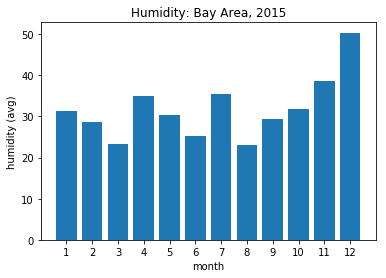

In [78]:
plot_bar(months, humidities, 
           xlabel = "month",
           ylabel = "humidity (avg)",
           title = "Humidity: Bay Area, 2015")

### Travel Startup
After graduating from USF, you found a startup that aims to provide personalized travel itineraries using big data analysis. Given your own personal preferences, build a plan for a year of travel across 5 locations. Or, in other words: pick 5 regions. What is the best time of year to visit them based on the dataset?

- One avenue here could be determining the comfort index for a region. You could incorporate several features: not too hot, not too cold, dry, humid, windy, etc. There are several different ways of calculating this available online, and you could also analyze how well your own metrics do.

In [74]:
sf_climate = spark.sql("\
SELECT \
    trunc(from_unixtime(timestamp DIV 1000), 'MM') AS year_month, \
    AVG(temperature_surface) AS avg_temp, \
    AVG(relative_humidity_zerodegc_isotherm) AS avg_humidity, \
    AVG(categorical_rain_yes1_no0_surface) AS avg_rain, \
    AVG(categorical_snow_yes1_no0_surface) AS avg_snow, \
    COUNT(*) AS count \
FROM nam_s_bayarea \
WHERE LEFT(geohash, 4) = '9q8y' \
GROUP BY year_month \
ORDER BY year_month \
")
sf_climate.cache()

KeyboardInterrupt: 

9q8y San Francisco, CA
9q5c Los Angeles, CA
9v6s Austin, TX
c20f Portland, OR
dr5r New York City, NY


### Escaping the fog
The locations that are the least foggy in the Bay Area are, `['9qb9t', '9qb8f', '9qbc8', '9qb9c', '9qbdh']` shown on [the map below](https://runkit.com/embed/4ttyt0e9kko7).

<img src="img/escaping_fog_map.png" alt="escaping_fog_map" style="width: 100%;"/>

In [20]:
escaping_fog = spark.sql("\
SELECT \
    LEFT(geohash, 5) AS geo, \
    AVG(visibility_surface) AS avg_visibility, \
    COUNT(*) AS count \
FROM nam_s_bayarea \
WHERE land_cover_land1_sea0_surface = 1 \
GROUP BY geo \
ORDER BY avg_visibility")

In [21]:
%%time
escaping_fog.show()

+-----+------------------+-----+
|  geo|    avg_visibility|count|
+-----+------------------+-----+
|9qb9t| 18761.74892659139|  396|
|9qb8f|19582.161214967942|  424|
|9qbc8| 19817.83294057392|  420|
|9qb9c|  20081.7811281906|  424|
|9qbdh| 20251.79378935285|  422|
|9qb8v|20520.581338662367|  416|
|9qbd8| 20670.64060296383|  394|
|9q9h2| 20815.24254091675|  421|
|9qbdp| 21052.57618587872|  424|
|9qbcg| 21064.37783503892|  398|
|9qbht|  21135.1341487752|  403|
|9q8z6|21338.007760015662|  414|
|9q8xw| 21481.07281812178|  436|
|9qbf6| 21490.69373505691|  435|
|9qb7s|21509.387960709613|  429|
|9qbc0|21612.027106097925|  428|
|9qb8q|21637.131621149103|  419|
|9qbk5| 21650.89019055269|  392|
|9qbc5| 21675.25514602661|  400|
|9q9he|21704.227402367625|  409|
+-----+------------------+-----+
only showing top 20 rows

CPU times: user 1.57 ms, sys: 3.24 ms, total: 4.81 ms
Wall time: 543 ms


In [22]:
least_foggy_list = escaping_fog.limit(5).collect()
list(map(lambda row: row['geo'], least_foggy_list))

['9qb9t', '9qb8f', '9qbc8', '9qb9c', '9qbdh']

### SolarWind, Inc.
Shown below are the top 3 land locations for:
- solar (lowest cloud cover)
- wind (highest wind speed)
- solar + wind (normalized wind speed subtracted by normalized cloud cover)
```
[
    'dpdd', 'c1f4', 'fd7e', # solar (red)
    'fb26', 'f9yb', 'f9xn', # wind (yellow)
    'f99e', 'f8zv', 'f8hu'  # solar + wind (green)
]
```

<img src="img/solar_wind_map.png" alt="solar_wind_map" style="width: 100%;"/>

In [58]:
nam_s.describe('total_cloud_cover_entire_atmosphere', 'surface_wind_gust_surface').show()
nam_s.select('total_cloud_cover_entire_atmosphere', 'surface_wind_gust_surface').show()

+-------+-----------------------------------+-------------------------+
|summary|total_cloud_cover_entire_atmosphere|surface_wind_gust_surface|
+-------+-----------------------------------+-------------------------+
|  count|                          108000000|                108000000|
|   mean|               -2.42109131147400...|        6.847670909482179|
| stddev|               4.914506718751981...|        4.462058868522337|
|    min|                      -1.0000036E20|             7.1111065E-4|
|    max|                              100.0|                 55.79795|
+-------+-----------------------------------+-------------------------+

+-----------------------------------+-------------------------+
|total_cloud_cover_entire_atmosphere|surface_wind_gust_surface|
+-----------------------------------+-------------------------+
|                               60.0|                 6.131471|
|                                0.0|                 5.616594|
|                              

In [60]:
solarwind1 = spark.sql("\
    SELECT \
        LEFT(geohash, 4) AS geo4, \
        AVG(total_cloud_cover_entire_atmosphere) AS avg_cloud_cover, \
        AVG(surface_wind_gust_surface) AS avg_wind_speed, \
        COUNT(*) AS count \
    FROM nam_s \
    WHERE land_cover_land1_sea0_surface = 1 \
    GROUP BY geo4")
solarwind1.cache()

DataFrame[geo4: string, avg_cloud_cover: double, avg_wind_speed: double, count: bigint]

In [61]:
%%time
min_max_cloud = solarwind1.agg(F.min('avg_cloud_cover'), F.max('avg_cloud_cover'))
(min_cloud, max_cloud) = min_max_cloud.collect()[0]

min_max_wind = solarwind1.agg(F.min('avg_wind_speed'), F.max('avg_wind_speed'))
(min_wind, max_wind) = min_max_wind.collect()[0]

solarwind2 = solarwind1.withColumn('norm_cloud', (solarwind1['avg_cloud_cover'] - min_cloud) / (max_cloud - min_cloud))
solarwind3 = solarwind2.withColumn('norm_wind', (solarwind2['avg_wind_speed'] - min_wind) / (max_wind - min_wind))
solarwind4 = solarwind3.withColumn('agg_solar_wind', solarwind3['norm_wind'] - solarwind3['norm_cloud'])
solarwind4.cache()

CPU times: user 15.4 ms, sys: 5.82 ms, total: 21.2 ms
Wall time: 6.73 s


In [62]:
%%time

solarwind4.orderBy(['norm_cloud'], ascending = True).limit(3).show()
solarwind4.orderBy(['norm_wind'], ascending = False).limit(3).show()
solarwind4.orderBy(['agg_solar_wind'], ascending = False).limit(3).show()

+----+--------------------+-----------------+-----+--------------------+-------------------+-------------------+
|geo4|     avg_cloud_cover|   avg_wind_speed|count|          norm_cloud|          norm_wind|     agg_solar_wind|
+----+--------------------+-----------------+-----+--------------------+-------------------+-------------------+
|dpdd|-8.02141664113873...|5.678629111956785|  374|                 0.0|0.49557403210169776|0.49557403210169776|
|c1f4|-7.85342885807823...| 5.42819967772324|  382|0.020942408376963297|0.46662370751669324| 0.4456812991397299|
|fd7e|-7.77204617561110...|6.670031750063204|  386| 0.03108808290155437| 0.6101828769264013| 0.5790947940248469|
+----+--------------------+-----------------+-----+--------------------+-------------------+-------------------+

+----+--------------------+------------------+-----+------------------+------------------+------------------+
|geo4|     avg_cloud_cover|    avg_wind_speed|count|        norm_cloud|         norm_wind|    agg_

In [63]:
solar_geos = list(map(lambda row: row['geo4'], solarwind4.orderBy(['norm_cloud'], ascending = True).limit(3).collect()))
wind_geos = list(map(lambda row: row['geo4'], solarwind4.orderBy(['norm_wind'], ascending = False).limit(3).collect()))
solarwind_geos = list(map(lambda row: row['geo4'], solarwind4.orderBy(['agg_solar_wind'], ascending = False).limit(3).collect()))
all_geos = solar_geos + wind_geos + solarwind_geos
all_geos

['dpdd', 'c1f4', 'fd7e', 'fb26', 'f9yb', 'f9xn', 'f99e', 'f8zv', 'f8hu']

### Climate Chart

Given a Geohash prefix, create a climate chart for the region. This includes high, low, and average temperatures, as well as monthly average rainfall (precipitation). 


In [64]:
geohash_prefix = "9q"

In [65]:
%%time
climate_query = f"\
SELECT \
    month(trunc(from_unixtime(timestamp DIV 1000), 'MM')) AS month, \
    MAX(temperature_surface) AS high_temp, \
    MIN(temperature_surface) AS low_temp, \
    AVG(precipitable_water_entire_atmosphere) AS avg_precip, \
    AVG(temperature_surface) AS avg_temp \
FROM nam_s \
WHERE LEFT(geohash, {len(geohash_prefix)}) = '{geohash_prefix}' \
GROUP BY month \
ORDER BY month"

climate_sqldf = spark.sql(climate_query)
climate_sqldf.show()

+-----+---------+---------+------------------+------------------+
|month|high_temp| low_temp|        avg_precip|          avg_temp|
+-----+---------+---------+------------------+------------------+
|    1|299.18396|247.05182|10.949247022320327| 281.1242307615161|
|    2| 302.9604| 250.0909|10.293374852570478| 284.5793024267133|
|    3|313.26297|251.41249| 9.813573460566202| 287.6185234531263|
|    4|317.08325|253.08893| 9.948537675421422| 287.2208176827174|
|    5|319.88965| 256.2046|13.317545840344588|290.57350651202256|
|    6| 325.2456|269.14746|15.924135436603695| 297.2251464420728|
|    7|323.49268| 270.7495|20.904758037709442|298.06162971831645|
|    8|325.75708|269.58057|19.140725221768776|298.74155090840844|
|    9|322.05542|268.25977|18.641422889053807| 297.2873654647769|
|   10| 317.0874|264.51636|17.232057861750718| 291.4313264400466|
|   11|307.45288|245.19685|  8.69144247587252|281.04314069422645|
|   12|301.52167|240.71106| 9.245780674733057|278.31525054165996|
+-----+---

In [137]:
climate_sqldf.write.format('csv').option('sep', '\t').save(f'hdfs://orion11:15000/climate-chart/{geohash_prefix}')

In [11]:
!hdfs dfs -getmerge /climate-chart/{geohash_prefix} ./climate-chart/{geohash_prefix}.tsv

/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


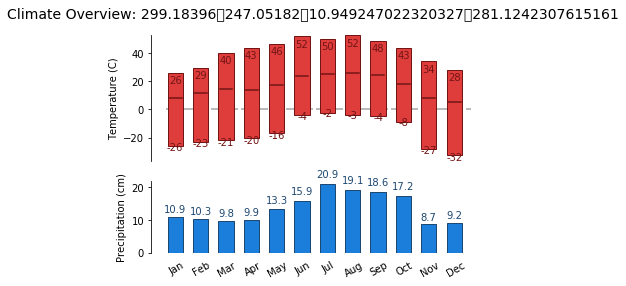

In [12]:
%run ./climate-chart/plot.py ./climate-chart/{geohash_prefix}.tsv

### Influencers

Determine how features influence each other using Pearson’s correlation coefficient (PCC). The output for this job should include (1) feature pairs sorted by absolute correlation coefficient, and (2) a correlation matrix visualization (heatmaps are a good option).

In [6]:
from pyspark.mllib.stat import Statistics

In [85]:
%%time

colnames = list(set(nam_s.columns) - {'Timestamp', 'Geohash'})
columns = nam_s.select(colnames).dropna()

CPU times: user 29.5 ms, sys: 9.87 ms, total: 39.4 ms
Wall time: 150 ms


In [87]:
%%time
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=colnames, outputCol=vector_col)
df_vector = assembler.transform(columns).select(vector_col)

# get correlation matrix
corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()

CPU times: user 119 ms, sys: 43.1 ms, total: 162 ms
Wall time: 9min 42s


In [91]:
corr_matrix

array([[ 1.00000000e+00,  1.79351663e-03,  3.71036214e-04, ...,
         4.88824451e-03, -9.99721817e-01,  9.16326246e-03],
       [ 1.79351663e-03,  1.00000000e+00, -2.42122617e-02, ...,
         3.65760435e-02, -5.55465906e-04,  3.98313756e-02],
       [ 3.71036214e-04, -2.42122617e-02,  1.00000000e+00, ...,
        -1.54071527e-03,  1.09312364e-03,  7.06034191e-02],
       ...,
       [ 4.88824451e-03,  3.65760435e-02, -1.54071527e-03, ...,
         1.00000000e+00, -6.95135867e-03,  5.70581465e-02],
       [-9.99721817e-01, -5.55465906e-04,  1.09312364e-03, ...,
        -6.95135867e-03,  1.00000000e+00, -8.39836629e-03],
       [ 9.16326246e-03,  3.98313756e-02,  7.06034191e-02, ...,
         5.70581465e-02, -8.39836629e-03,  1.00000000e+00]])

In [92]:
import pandas as pd

corr_df = pd.DataFrame(
                    corr_matrix, 
                    index=colnames, 
                    columns=colnames)

corr_df

,planetary_boundary_layer_height_surface,convective_inhibition_surface,v-component_of_wind_tropopause,geopotential_height_zerodegc_isotherm,wilting_point_surface,total_cloud_cover_entire_atmosphere,v-component_of_wind_maximum_wind,convective_available_potential_energy_surface,downward_short_wave_rad_flux_surface,vegetation_surface,...,albedo_surface,transpiration_stress-onset_soil_moisture_surface,categorical_freezing_rain_yes1_no0_surface,sensible_heat_net_flux_surface,pressure_maximum_wind,u-component_of_wind_pblri,pressure_reduced_to_msl_msl,ice_cover_ice1_no_ice0_surface,latent_heat_net_flux_surface,categorical_snow_yes1_no0_surface
planetary_boundary_layer_height_surface,1.000000,0.001794,0.000371,0.077687,0.001808,0.999740,0.000814,-0.001194,0.036934,-0.003588,...,0.006610,0.002095,0.001370,-0.999728,0.003978,0.007974,-0.010304,0.004888,-0.999722,0.009163
convective_inhibition_surface,0.001794,1.000000,-0.024212,-0.179423,-0.042799,0.000620,-0.018264,0.012497,0.023758,-0.097096,...,0.046808,-0.033197,0.006626,-0.000564,0.054795,0.035664,0.077376,0.036576,-0.000555,0.039831
v-component_of_wind_tropopause,0.000371,-0.024212,1.000000,0.057071,-0.039184,-0.001077,0.920468,0.012024,-0.020616,0.023379,...,-0.073445,-0.035227,0.021656,0.001102,-0.011333,-0.061425,-0.324675,-0.001541,0.001093,0.070603
geopotential_height_zerodegc_isotherm,0.077687,-0.179423,0.057071,1.000000,-0.213858,0.078157,0.041798,0.402526,0.194896,0.101894,...,-0.543453,-0.272832,-0.041691,-0.078186,-0.317744,-0.353898,-0.036012,-0.241447,-0.077728,-0.260997
wilting_point_surface,0.001808,-0.042799,-0.039184,-0.213858,1.000000,-0.000072,-0.026885,-0.170315,-0.019501,0.629240,...,0.430154,0.938764,0.012555,0.000269,0.051261,0.123658,0.007354,-0.127419,-0.000312,0.067920
total_cloud_cover_entire_atmosphere,0.999740,0.000620,-0.001077,0.078157,-0.000072,1.000000,-0.000632,-0.000768,0.032997,-0.006132,...,0.008121,-0.000061,0.001308,-0.999999,0.002933,0.005311,-0.006163,0.006756,-0.999998,0.008277
v-component_of_wind_maximum_wind,0.000814,-0.018264,0.920468,0.041798,-0.026885,-0.000632,1.000000,0.014833,-0.021120,0.029659,...,-0.061991,-0.022086,0.019678,0.000663,-0.006494,-0.042075,-0.293132,-0.000943,0.000655,0.062330
convective_available_potential_energy_surface,-0.001194,0.012497,0.012024,0.402526,-0.170315,-0.000768,0.014833,1.000000,0.176077,-0.033667,...,-0.216782,-0.211889,-0.012910,0.000775,-0.122871,-0.215216,-0.090533,-0.074397,0.001145,-0.077775
downward_short_wave_rad_flux_surface,0.036934,0.023758,-0.020616,0.194896,-0.019501,0.032997,-0.021120,0.176077,1.000000,0.061533,...,-0.082855,-0.026285,-0.014548,-0.032232,-0.024904,-0.026223,0.020322,-0.020488,-0.032353,-0.071144
vegetation_surface,-0.003588,-0.097096,0.023379,0.101894,0.629240,-0.006132,0.029659,-0.033667,0.061533,1.000000,...,0.072250,0.674752,-0.006440,0.006387,-0.008531,0.063553,-0.066619,-0.096400,0.006103,-0.056003


In [93]:
corr_df.to_csv("./corr-heatmap/correlation-matrix", sep=" ", index=False, header=False)

/home2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


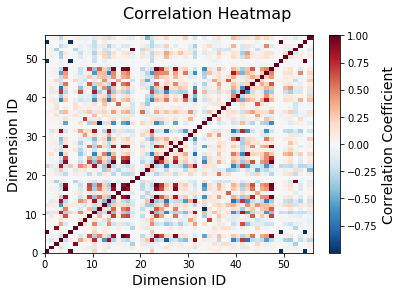

In [94]:
%run ./corr-heatmap/plot.py ./corr-heatmap/correlation-matrix

In [121]:
corr_list = [] 
for c in range(len(corr_df)):
    for r in range(c):
        corr_list.append([corr_df.index[c], corr_df.columns[r], corr_df.iloc[r,c]])

In [163]:
import math
corr_list_df = pd.DataFrame(corr_list, columns=['feat_a','feat_b','corr_val']) \
    .assign(corr_abs=corr_list_df.corr_val.abs()) \
    .sort_values(by='corr_abs', ascending=False)
#     .assign(corr_abs=corr_list_df.apply(lambda row: math.fabs(row['corr_val']), axis = 1)) \
corr_list_df

,feat_a,feat_b,corr_val,corr_abs
124,direct_evaporation_cease_soil_moisture_surface,wilting_point_surface,1.000000,1.000000
270,land_cover_land1_sea0_surface,soil_porosity_surface,1.000000,1.000000
1181,sensible_heat_net_flux_surface,total_cloud_cover_entire_atmosphere,-0.999999,0.999999
1480,latent_heat_net_flux_surface,sensible_heat_net_flux_surface,0.999999,0.999999
1436,latent_heat_net_flux_surface,total_cloud_cover_entire_atmosphere,-0.999998,0.999998
10,total_cloud_cover_entire_atmosphere,planetary_boundary_layer_height_surface,0.999740,0.999740
1176,sensible_heat_net_flux_surface,planetary_boundary_layer_height_surface,-0.999728,0.999728
1431,latent_heat_net_flux_surface,planetary_boundary_layer_height_surface,-0.999722,0.999722
539,pressure_surface,geopotential_height_surface,-0.991183,0.991183
1098,transpiration_stress-onset_soil_moisture_surface,soil_porosity_surface,0.990802,0.990802


In [166]:
corr_list_df.head(50)

,feat_a,feat_b,corr_val,corr_abs
124,direct_evaporation_cease_soil_moisture_surface,wilting_point_surface,1.000000,1.000000
270,land_cover_land1_sea0_surface,soil_porosity_surface,1.000000,1.000000
1181,sensible_heat_net_flux_surface,total_cloud_cover_entire_atmosphere,-0.999999,0.999999
1480,latent_heat_net_flux_surface,sensible_heat_net_flux_surface,0.999999,0.999999
1436,latent_heat_net_flux_surface,total_cloud_cover_entire_atmosphere,-0.999998,0.999998
10,total_cloud_cover_entire_atmosphere,planetary_boundary_layer_height_surface,0.999740,0.999740
1176,sensible_heat_net_flux_surface,planetary_boundary_layer_height_surface,-0.999728,0.999728
1431,latent_heat_net_flux_surface,planetary_boundary_layer_height_surface,-0.999722,0.999722
539,pressure_surface,geopotential_height_surface,-0.991183,0.991183
1098,transpiration_stress-onset_soil_moisture_surface,soil_porosity_surface,0.990802,0.990802


### Prediction/Classification: 

Using what you learned above as your guide, choose a feature to predict or classify via machine learning models in MLlib. You will need to explain:
- The feature you will predict/classify
- Features used to train the model
- How you partitioned your data

# Sampling

We create a subset of the data for the San Francisco Bay Area with the following Geohashes:

<img src="img/bay_area_geohashes_map.png" alt="bay_area_geohashes_map.png" style="width: 100%;"/>

In [15]:
nam_s_bayarea = spark.sql("\
SELECT * \
FROM nam_s \
WHERE LEFT(geohash, 4) IN ( \
 '9q8x', '9q8z', '9q8y', '9q8v', '9q8u', '9q8g', \
 '9q9p', '9q9n', '9q9j', '9q9h', '9q95', '9q9r', '9q9q', '9q9m', '9q9k', '9q97', '9q9e', \
 '9qb3', '9q95', '9qb6', '9qb7', '9qb8', '9qb9', '9qbb', '9qbc', '9qbd', '9qbe', '9qbf', '9qbg', '9qbh', '9qbk', '9qbs', \
 '9qc0', '9qc1', '9qc2', '9qc3', '9qc4', '9qc5', '9qc6', '9qch' \
)")
nam_s_bayarea.createOrReplaceTempView('nam_s_bayarea')
nam_s_bayarea.cache()

DataFrame[Timestamp: bigint, Geohash: string, geopotential_height_lltw: float, water_equiv_of_accum_snow_depth_surface: float, drag_coefficient_surface: float, sensible_heat_net_flux_surface: float, categorical_ice_pellets_yes1_no0_surface: float, visibility_surface: float, number_of_soil_layers_in_root_zone_surface: float, categorical_freezing_rain_yes1_no0_surface: float, pressure_reduced_to_msl_msl: float, upward_short_wave_rad_flux_surface: float, relative_humidity_zerodegc_isotherm: float, categorical_snow_yes1_no0_surface: float, u-component_of_wind_tropopause: float, surface_wind_gust_surface: float, total_cloud_cover_entire_atmosphere: float, upward_long_wave_rad_flux_surface: float, land_cover_land1_sea0_surface: float, vegitation_type_as_in_sib_surface: float, v-component_of_wind_pblri: float, albedo_surface: float, lightning_surface: float, ice_cover_ice1_no_ice0_surface: float, convective_inhibition_surface: float, pressure_surface: float, transpiration_stress-onset_soil_mo

In [55]:
nam_s_bayarea.write.format('csv').save('hdfs://orion11:15000/nam_s_bayarea')